In [1]:
# Freeing CUDA memory: https://stackoverflow.com/questions/55322434/how-to-clear-cuda-memory-in-pytorch 
import torch 
from VRP_Net_L import VRPNet_L 
from matplotlib import pyplot as plt 
from utils import * 
import os 
import matplotlib.pyplot as plt 
from torchinfo import summary 
import numpy as np 
from inference import inference 
from pathlib import Path 
import time
from tqdm import tqdm
from DatasetGenerator import generate_dataset, torchFLPO_2_numpyFLPO 
from viz import plot_UAV_FLPO, plot_UAV_FLPO_3D


In [2]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu') 

print("Running on: " , device) 

num_facilities = np.linspace(10,200,20) # number of facilities 

city_dim = 2
Data_1 = []
Data_2 = []
Data_3 = []
Data_4 = []

for i in num_facilities:
    i = int(i)

    num_drones=1
    n_drone_clusters = 1
    drone_cluster_split = np.random.uniform(0.0, 1.0, n_drone_clusters)
    drone_cluster_split = drone_cluster_split / np.sum(drone_cluster_split)
    num_distinct_ends=1
    START_locs, F_base, END_locs = generate_dataset(
        num_drones, 
        n_drone_clusters, 
        drone_cluster_split, 
        i, city_dim, device, drone_cluster_std_range=[0.02, 0.05], F_noise_std=0.1,num_distinct_ends=num_distinct_ends
    )
    data = [START_locs, F_base, END_locs]
    Data_1.append(data)

    # num_drones = 50
    # n_drone_clusters = 10
    # drone_cluster_split = np.random.uniform(0.0, 1.0, n_drone_clusters)
    # drone_cluster_split = drone_cluster_split / np.sum(drone_cluster_split)
    # START_locs, F_base, END_locs = generate_dataset(
    #     num_drones, 
    #     n_drone_clusters, 
    #     drone_cluster_split, 
    #     i, dim_, device, drone_cluster_std_range=[0.02, 0.05], F_noise_std=0.1,num_distinct_ends=num_distinct_ends
    # )
    # data = [START_locs, F_base, END_locs]
    # Data_2.append(data)

    # num_drones = 100
    # n_drone_clusters = 20
    # drone_cluster_split = np.random.uniform(0.0, 1.0, n_drone_clusters)
    # drone_cluster_split = drone_cluster_split / np.sum(drone_cluster_split)
    # START_locs, F_base, END_locs = generate_dataset(
    #     num_drones, 
    #     n_drone_clusters, 
    #     drone_cluster_split, 
    #     i, dim_, device, drone_cluster_std_range=[0.02, 0.05], F_noise_std=0.1,num_distinct_ends=num_distinct_ends
    # )
    # data = [START_locs, F_base, END_locs]
    # Data_3.append(data)

    # num_drones = 200
    # n_drone_clusters = 30
    # drone_cluster_split = np.random.uniform(0.0, 1.0, n_drone_clusters)
    # drone_cluster_split = drone_cluster_split / np.sum(drone_cluster_split)
    # START_locs, F_base, END_locs = generate_dataset(
    #     num_drones, 
    #     n_drone_clusters, 
    #     drone_cluster_split, 
    #     i, dim_, device, drone_cluster_std_range=[0.02, 0.05], F_noise_std=0.1,num_distinct_ends=num_distinct_ends
    # )
    # data = [START_locs, F_base, END_locs]
    # Data_4.append(data)

Running on:  cpu


In [3]:
num_facilities

array([ 10.,  20.,  30.,  40.,  50.,  60.,  70.,  80.,  90., 100., 110.,
       120., 130., 140., 150., 160., 170., 180., 190., 200.])

In [4]:
torch.cuda.empty_cache()
model_classes = {"VRPNet_L": VRPNet_L}
weights_address = (
    Path("Saved_models") /
    "VRPNet_L_lr1e-04_bs32_ep60000_samples1920000_cities50_inputdim2_"
    "workers0_hidden64_enc1_dec1_heads8_dropout0.30_"
    "train_PO_2025_05_17_22_43_32last_model.pth"
)
vrp_net = load_model(
    weights_address, model_classes, weights_only=True, device=device
)
for param in vrp_net.parameters():
    param.requires_grad = False
vrp_net.eval()
print('VRP_L NET loaded.')
print(summary(vrp_net))


Model created.
VRP_L NET loaded.
Layer (type:depth-idx)                                                 Param #
VRPNet_L                                                               --
├─LinearAttnEncoder: 1-1                                               2,048
│    └─ModuleList: 2-1                                                 --
│    │    └─MultiheadAttention: 3-1                                    (66,048)
│    │    └─MultiheadAttention: 3-2                                    (66,048)
│    │    └─MultiheadAttention: 3-3                                    (66,048)
│    │    └─MultiheadAttention: 3-4                                    (66,048)
│    │    └─MultiheadAttention: 3-5                                    (66,048)
│    │    └─MultiheadAttention: 3-6                                    (66,048)
│    └─ModuleList: 2-2                                                 --
│    │    └─MultiheadAttention: 3-7                                    (66,048)
│    │    └─MultiheadAttentio

### Compute gradient via Sampling and SPN for one datapoint

In [5]:
import GD 
n_path_samples = 1000
start_locs, f_base, end_locs = Data_1[0]
f_base_clone = f_base.clone().detach().requires_grad_(True)
beta = 1e-3
tic = time.time()
_, _, G_sampling = GD.sampling_GD_at_beta(
    f_base_clone, 
    start_locs,
    end_locs,
    vrp_net,
    n_path_samples,
    beta,
    stepsize=0.0,
    iters=1
)
toc = time.time()
ct = toc - tic
print(ct)

0.8468120098114014


### Compute gradient via uavFLPO

In [6]:
import uavFLPO
start_locs, f_base, end_locs = Data_1[0]
start_locs_np, f_base_np, end_locs_np = torchFLPO_2_numpyFLPO(start_locs, end_locs, f_base, city_dim, scale=1.0)
n_facilities = f_base_np.shape[0]
uav_flpo = uavFLPO.FLPO(
    start_locs_np,
    end_locs_np,
    n_facilities,
    scale=1.0,
    disType='sqeuclidean',
    selfHop=False
)
tic = time.time() 
D_s, _ = uav_flpo.returnStagewiseCost(f_base_np)
GD_s, _ = uav_flpo.returnStagewiseGrad(f_base_np)
_, _, _, _, P_s = uav_flpo.backPropDP(D_s, beta, returnPb=True)
GV, G_flpo = uav_flpo.backPropDP_grad(GD_s, P_s)
toc = time.time()
print(toc-tic)




0.0018429756164550781


In [7]:
G_sampling.squeeze(), G_flpo

(tensor([[-0.4452, -0.4854],
         [-0.1385,  0.3425],
         [ 0.1063,  0.4555],
         [ 0.3567,  0.1635],
         [-1.2351,  0.2987],
         [-0.0328,  0.3360],
         [ 0.1206,  0.2248],
         [-0.2966,  0.4126],
         [ 0.7250,  0.2059],
         [ 0.1838, -0.0888]], grad_fn=<SqueezeBackward0>),
 array([[-0.48295512, -0.72702914],
        [-0.116082  ,  0.23660254],
        [ 0.18424486,  0.42820191],
        [ 0.4296284 ,  0.07532386],
        [-1.44257831,  0.23867794],
        [-0.00552582,  0.26189012],
        [ 0.19183897,  0.10223013],
        [-0.27775334,  0.32341769],
        [ 0.9177687 ,  0.1236864 ],
        [ 0.2621155 , -0.24849426]]))

In [8]:
np.linalg.norm(G_flpo - G_sampling.squeeze().detach().numpy()) #/np.linalg.norm(G_flpo)

0.4982540001964865

# Calculating time for SNN

In [12]:
beta = 1e4
n_path_samples = 1000
times_1_L = []
times_1_F = []
grad_norm_error_1 = []

torch.cuda.empty_cache()
for data in tqdm(Data_1):
    s = time.time()
    start_locs, f_base, end_locs = data
    start_locs_np, f_base_np, end_locs_np = torchFLPO_2_numpyFLPO(start_locs, end_locs, f_base, city_dim, scale=1.0)
    f_base_clone = f_base.clone().detach().requires_grad_(True)
    n_facilities = f_base_np.shape[0]

    tic = time.time()
    _, _, G_sampling = GD.sampling_GD_at_beta(
        f_base_clone, 
        start_locs,
        end_locs,
        vrp_net,
        n_path_samples,
        beta,
        stepsize=0.0,
        iters=1
    )
    toc = time.time()
    times_1_L.append(toc - tic)  
    torch.cuda.empty_cache()

    uav_flpo = uavFLPO.FLPO(
        start_locs_np,
        end_locs_np,
        n_facilities,
        scale=1.0,
        disType='sqeuclidean',
        selfHop=False
    )
    tic = time.time() 
    D_s, _ = uav_flpo.returnStagewiseCost(f_base_np)
    GD_s, _ = uav_flpo.returnStagewiseGrad(f_base_np)
    _, _, _, _, P_s = uav_flpo.backPropDP(D_s, beta, returnPb=True)
    GV, G_flpo = uav_flpo.backPropDP_grad(GD_s, P_s)
    toc = time.time()
    times_1_F.append(toc-tic)

    grad_norm_error_1.append(np.linalg.norm(G_flpo - G_sampling.squeeze().detach().numpy()))


100%|██████████| 20/20 [02:05<00:00,  6.29s/it]


In [5]:

# times_1_L=[]
# times_2_L=[]
# times_3_L=[]
# times_4_L=[]
# torch.cuda.empty_cache()
# for data in tqdm(Data_1):
#     s = time.time()
#     with torch.no_grad():
#         inference(data,vrp_net,'Greedy')
#     times_1_L.append(time.time()-s)
#     torch.cuda.empty_cache()
# for data in tqdm(Data_2):
#     s = time.time()
#     with torch.no_grad():
#         inference(data,vrp_net,'Greedy')
#     times_2_L.append(time.time()-s)
#     torch.cuda.empty_cache()
# for data in tqdm(Data_3):
#     s = time.time()
#     with torch.no_grad():
#         inference(data,vrp_net,'Greedy')
#     times_3_L.append(time.time()-s)
#     torch.cuda.empty_cache()
# for data in tqdm(Data_4):
#     s = time.time()
#     with torch.no_grad():
#         inference(data,vrp_net,'Greedy')
#     times_4_L.append(time.time()-s)
#     torch.cuda.empty_cache()

100%|██████████| 20/20 [00:30<00:00,  1.55s/it]


# Calculating time for Original Gibb's Distribution

In [10]:
# times_1_F = []

# for data in tqdm(Data_1):
#     start_locs, f_base, end_locs = data


100%|██████████| 20/20 [00:40<00:00,  2.04s/it]


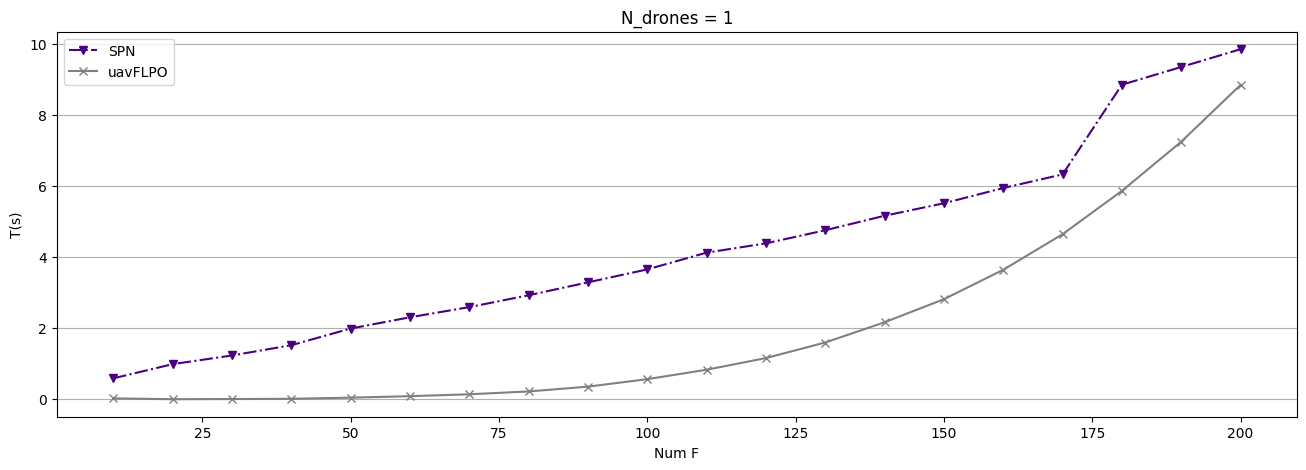

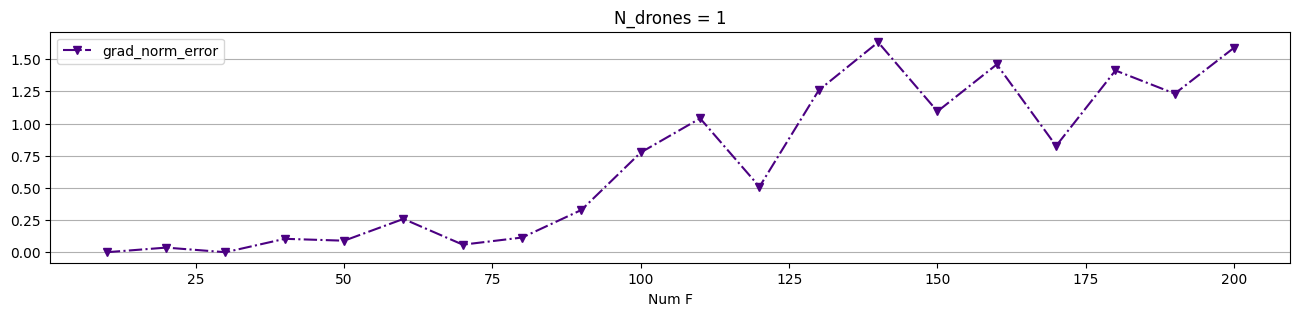

In [13]:
color1 = 'indigo'
color2 = 'gray'
color3 = 'orange'
linestyle1 = '-.'
linestyle2 = '-'
linestyle3 = '--'

plt.figure(figsize=(16,5))
plt.plot(num_facilities,times_1_L,linestyle1,marker='v',color=color1,label='SPN')
plt.plot(num_facilities,times_1_F,linestyle2,marker='x',color=color2,label='uavFLPO')
plt.xlabel('Num F')
plt.ylabel('T(s)')
plt.title('N_drones = 1')
# plt.yticks(np.linspace(0,35,15))
plt.grid(axis='y',alpha=1)
plt.legend()

plt.figure(figsize=(16,3))
plt.plot(num_facilities,grad_norm_error_1,linestyle1,marker='v',color=color1,label='grad_norm_error')
plt.xlabel('Num F')
# plt.ylabel('')
plt.title('N_drones = 1')
# plt.yticks(np.linspace(0,35,15))
plt.grid(axis='y',alpha=1)
plt.legend()
plt.show()

In [11]:
# times_1_F=[]
# times_2_F=[]
# times_3_F=[]
# times_4_F=[]
# torch.cuda.empty_cache()
# for data in tqdm(Data_1):
#     s = time.time()
#     with torch.no_grad():
#         generate_true_labels(data,10)
#     times_1_F.append(time.time()-s)
#     torch.cuda.empty_cache()
# for data in tqdm(Data_2):
#     s = time.time()
#     with torch.no_grad():
#         generate_true_labels(data,10)
#     times_2_F.append(time.time()-s)
#     torch.cuda.empty_cache()
# for data in tqdm(Data_3):
#     s = time.time()
#     with torch.no_grad():
#         generate_true_labels(data,10)
#     times_3_F.append(time.time()-s)
#     torch.cuda.empty_cache()
# for data in tqdm(Data_4):
#     s = time.time()
#     with torch.no_grad():
#         generate_true_labels(data,10)
#     times_4_F.append(time.time()-s)
#     torch.cuda.empty_cache()

In [8]:
times_1_G=[]
times_2_G=[]
times_3_G=[]
times_4_G=[]
torch.cuda.empty_cache()
for data in tqdm(Data_1):
    s = time.time()
    with torch.no_grad():
        generate_true_labels1(data,10)
    times_1_G.append(time.time()-s)
    torch.cuda.empty_cache()
for data in tqdm(Data_2):
    s = time.time()
    with torch.no_grad():
        generate_true_labels1(data,10)
    times_2_G.append(time.time()-s)
    torch.cuda.empty_cache()
for data in tqdm(Data_3):
    s = time.time()
    with torch.no_grad():
        generate_true_labels1(data,10)
    times_3_G.append(time.time()-s)
    torch.cuda.empty_cache()
for data in tqdm(Data_4):
    s = time.time()
    with torch.no_grad():
        generate_true_labels1(data,10)
    times_4_G.append(time.time()-s)
    torch.cuda.empty_cache()

100%|██████████| 20/20 [24:26<00:00, 73.32s/it] 


# Save the data

In [ ]:
# import pickle

# action_runtime_data = {}

# action_runtime_data['times_1_L'] = times_1_L
# action_runtime_data['times_2_L'] = times_2_L
# action_runtime_data['times_3_L'] = times_3_L
# action_runtime_data['times_4_L'] = times_4_L

# action_runtime_data['times_1_F'] = times_1_F
# action_runtime_data['times_2_F'] = times_2_F
# action_runtime_data['times_3_F'] = times_3_F
# action_runtime_data['times_4_F'] = times_4_F

# action_runtime_data['times_1_G'] = times_1_G
# action_runtime_data['times_2_G'] = times_2_G
# action_runtime_data['times_3_G'] = times_3_G
# action_runtime_data['times_4_G'] = times_4_G

# filename = 'action_runtime_data.pkl'
# with open(filename, 'wb') as file:
#     pickle.dump(action_runtime_data, file)


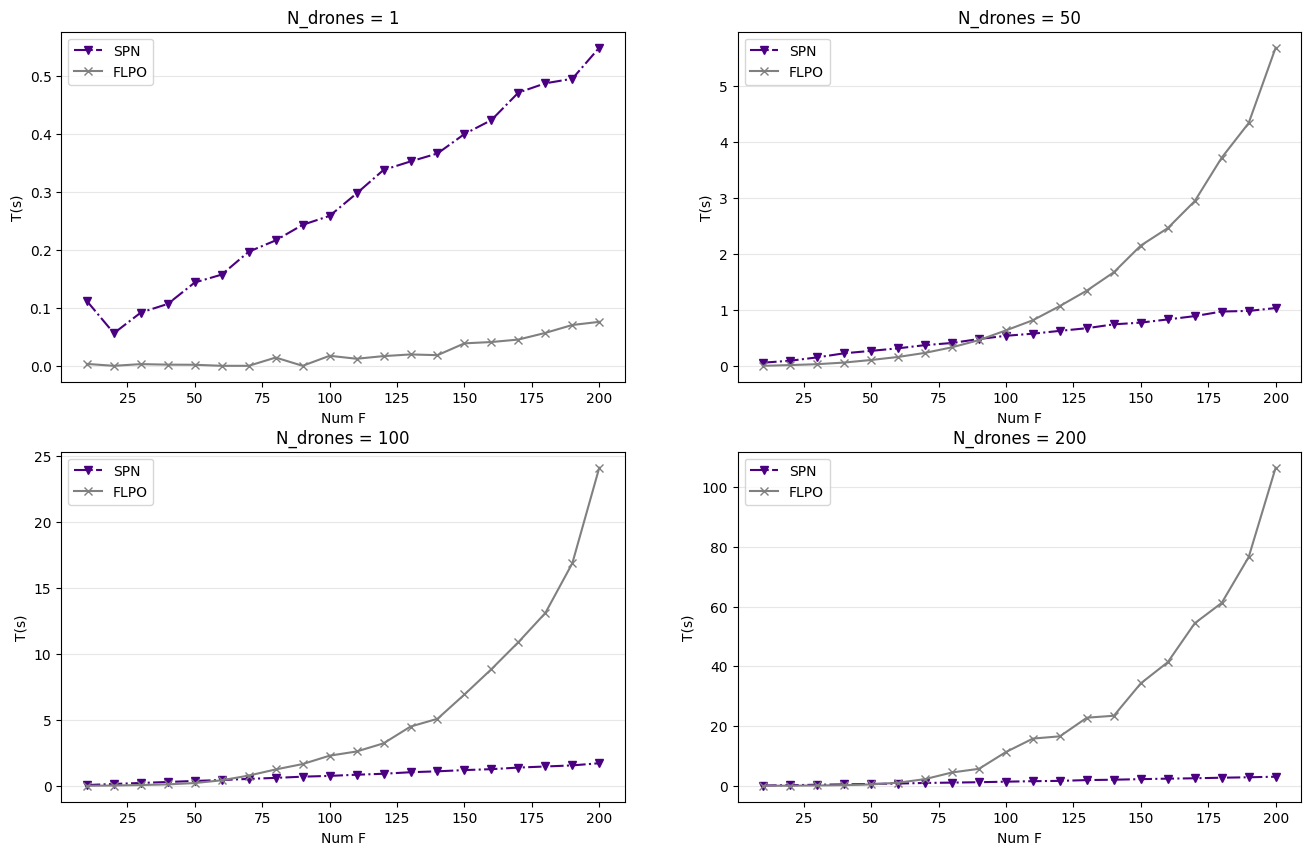

In [7]:
color1 = 'indigo'
color2 = 'gray'
color3 = 'orange'
linestyle1 = '-.'
linestyle2 = '-'
linestyle3 = '--'

plt.figure(figsize=(16,10))

plt.subplot(2,2,1)
plt.plot(num_facilities,times_1_L,linestyle1,marker='v',color=color1,label='SPN')
plt.plot(num_facilities,times_1_F,linestyle2,marker='x',color=color2,label='FLPO')
# plt.plot(num_facilities,times_1_G,linestyle3,marker='o',color=color3,label='FLPO_DP_1')
# plt.yscale('log')
plt.xlabel('Num F')
plt.ylabel('T(s)')
plt.title('N_drones = 1')
# plt.yticks(np.linspace(0,35,15))
plt.grid(axis='y',alpha=0.3)
plt.legend()

plt.subplot(2,2,2)
plt.plot(num_facilities,times_2_L,linestyle1,marker='v',color=color1,label='SPN')
plt.plot(num_facilities,times_2_F,linestyle2,marker='x',color=color2,label='FLPO')
# plt.plot(num_facilities,times_2_G,linestyle3,marker='o',color=color3,label='FLPO_DP')
# plt.yscale('log')
plt.xlabel('Num F')
plt.ylabel('T(s)')
plt.title('N_drones = 50')
# plt.yticks(np.linspace(0,35,15))
plt.grid(axis='y',alpha=0.3)
plt.legend()

plt.subplot(2,2,3)
plt.plot(num_facilities,times_3_L,linestyle1,marker='v',color=color1,label='SPN')
plt.plot(num_facilities,times_3_F,linestyle2,marker='x',color=color2,label='FLPO')
# plt.plot(num_facilities,times_3_G,linestyle3,marker='o',color=color3,label='FLPO_DP')
# plt.yscale('log')
plt.xlabel('Num F')
plt.ylabel('T(s)')
plt.title('N_drones = 100')
# plt.yticks(np.linspace(0,35,15))
plt.grid(axis='y',alpha=0.3)
plt.legend()

plt.subplot(2,2,4)
plt.plot(num_facilities,times_4_L,linestyle1,marker='v',color=color1,label='SPN')
plt.plot(num_facilities,times_4_F,linestyle2,marker='x',color=color2,label='FLPO')
# plt.plot(num_facilities,times_4_G,linestyle3,marker='o',color=color3,label='FLPO_DP')
# plt.yscale('log')
plt.xlabel('Num F')
plt.ylabel('T(s)')
plt.title('N_drones = 200')
# plt.yticks(np.linspace(0,35,15))
plt.grid(axis='y',alpha=0.3)
plt.legend()


# plt.plot(num_facilities,times_1_L,linestyle1,marker='v',color=color1,label='SPN_1')
# plt.plot(num_facilities,times_2_L,linestyle1,marker='o',color=color1,label='SPN_50')
# plt.plot(num_facilities,times_3_L,linestyle1,marker='^',color=color1,label='SPN_100')
# plt.plot(num_facilities,times_4_L,linestyle1,marker='x',color=color1,label='SPN_200')

# plt.plot(num_facilities,times_1_F,linestyle2,marker='v',color=color2,label='FLPO_1')
# plt.plot(num_facilities,times_2_F,linestyle2,marker='o',color=color2,label='FLPO_50')
# plt.plot(num_facilities,times_3_F,linestyle2,marker='^',color=color2,label='FLPO_100')
# plt.plot(num_facilities,times_4_F,linestyle2,marker='x',color=color2,label='FLPO_200')

# plt.plot(num_facilities,times_1_G,linestyle3,marker='v',color=color3,label='FLPO_DP_1')
# plt.plot(num_facilities,times_2_G,linestyle3,marker='o',color=color3,label='FLPO_DP_50')
# plt.plot(num_facilities,times_3_G,linestyle3,marker='^',color=color3,label='FLPO_DP_100')
# plt.plot(num_facilities,times_4_F,linestyle3,marker='x',color=color3,label='FLPO_DP_200')

# plt.legend()
# plt.title('GPU Runtime Comparison (Total Route)')
plt.savefig("SpeedTestResults.svg")

plt.show()
